# Challenge - 3rd scenery

In this scenery, it is requested to, as a machine learning engineer, build a model that can identify scenes and infer from it if is day or night in the photo. To do so, it will be used a provided dataset for train and test purposes, based on AMOS dataset. For experimentation purposes, it will be added some more images to verify if this could provide model performance enhancement.

Importing needed libraries

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

Creating train and test image lists.

In [84]:
def load_dataset(dataset_type):
    img_array = []

    root_folder = './dataset'
    scene_types = ['day', 'night']


    for scene_type in scene_types:
        for image in glob.glob(os.path.join(root_folder, dataset_type, scene_type, '*')):
            im = cv2.imread(image)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

            if im is not None:
                img_array.append((im, scene_type))

    img_array

    return img_array

In [85]:
train_dataset = load_dataset('training')
test_dataset = load_dataset('test')

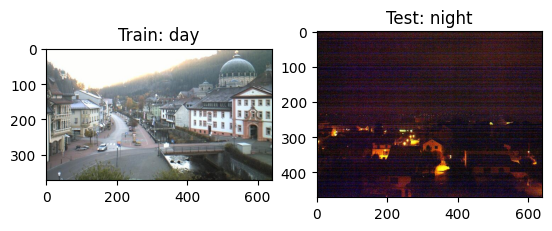

In [89]:
_, axis = plt.subplots(1, 2)
axis[0].imshow(train_dataset[0][0])
img_title = "Train: {}".format(train_dataset[0][1])
axis[0].set_title(img_title)
axis[1].imshow(test_dataset[150][0])
img_title = "Test: {}".format(test_dataset[150][1])
axis[1].set_title(img_title)
plt.show()

Resize images to fit required conditions (1000 x 600)

In [90]:
def dataset_resize(dataset):
    output_array = []
    for image in dataset:
        final_img = cv2.resize(image[0], (1000, 600), interpolation=cv2.INTER_AREA)

        output_array.append((final_img, image[1]))
    return output_array

In [91]:
resized_train_dataset = dataset_resize(train_dataset)
resized_test_dataset = dataset_resize(test_dataset)

Text(0.5, 1.0, 'Test: night')

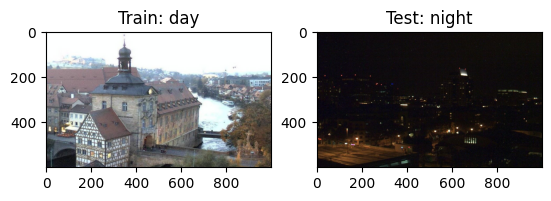

In [93]:
_, axis = plt.subplots(1, 2)
axis[0].imshow(resized_train_dataset[2][0])
img_title = f"Train: {resized_train_dataset[2][1]}"
axis[0].set_title(img_title)
axis[1].imshow(resized_test_dataset[120][0])
img_title = f"Test: {resized_test_dataset[120][1]}"
axis[1].set_title(img_title)

Extracting average brightness

In [94]:
def avg_bright(dataset):
    output_arr = []

    for image in dataset:
        hsv_img = cv2.cvtColor(image[0], cv2.COLOR_RGB2HSV)
        value = np.sum(hsv_img[:,:,2])
        pixel = hsv_img.shape[0] * hsv_img.shape[1]
        avg_brt = value / pixel

        image = (image[0], image[1], avg_brt)
        output_arr.append(image)

    return output_arr

In [95]:
bright_train_dataset = avg_bright(resized_train_dataset)
bright_test_dataset = avg_bright(resized_test_dataset)

In [96]:
bright_test_dataset[0][2]

141.49402

In [97]:
def encode_label(dataset):
    output_arr = []
    for image in dataset:
        image = list(image)
        image[1] = 1 if image[1] == 'day' else 0
        image = tuple(image)
        output_arr.append(image)

    return output_arr

In [98]:
std_train_dataset = encode_label(bright_train_dataset)
std_test_dataset = encode_label(bright_test_dataset)

## Classifier creation

As requested, it will be used ScikitLearn Decision Tree Classifier. The main goal is achieve 90% accuracy.

In [100]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state=42)

Feature extraction from train and test datasets.

In [101]:
def extract_features(dataset):
    x = []
    y = []

    for image in dataset:
        x.append(image[2])
        y.append(image[1])

    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)

    return x, y

In [102]:
x_train, y_train = extract_features(std_train_dataset)
x_test, y_test = extract_features(std_test_dataset)

In [103]:
len(x_train)

240

In [104]:
classifier.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [105]:
predictions = classifier.predict(x_test)

Text(0.5, 1.0, 'day')

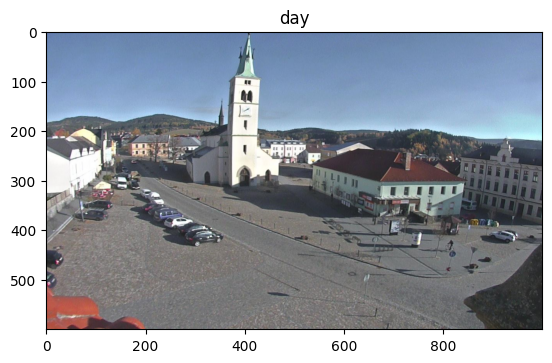

In [106]:
scenery_name = 'day' if predictions[0] == 1 else 'night'

plt.imshow(std_test_dataset[0][0])
plt.title(scenery_name)

Getting scores (accuracy and precision) for predictions

In [107]:
from sklearn.metrics import accuracy_score, precision_score

acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions)

print(f"Accuracy: {acc}; Precision: {prec}")

Accuracy: 0.91875; Precision: 0.8941176470588236


As shown above, model presented an accuracy of 91.88% and precision of 89.41%. As a suggestion, let's create a new model using color channels average intensity along with brightness.

In [114]:
def extract_new_features(dataset):
    x = []
    y = []

    for image in dataset:
        R, G, B = cv2.split(image[0])
        r = np.average(R)
        g = np.average(G)
        b = np.average(B)
        rgbh = [r, g, b, image[2]]
        x.append(rgbh)
        y.append(image[1])

    return x, y

In [115]:
new_x_train, new_y_train = extract_new_features(std_train_dataset)
new_x_test, new_y_test = extract_new_features(std_test_dataset)

In [117]:
new_classifier = DecisionTreeClassifier(random_state=42)
new_classifier.fit(new_x_train, new_y_train)

DecisionTreeClassifier(random_state=42)

In [118]:
new_predictions = new_classifier.predict(new_x_test)

In [119]:
acc = accuracy_score(new_y_test, new_predictions)
prec = precision_score(new_y_test, new_predictions)

print(f"Accuracy: {acc}; Precision: {prec}")

Accuracy: 0.96875; Precision: 0.9629629629629629


As we can see, adding mean RGB intensity generated an improvement of about 5% of accuracy, and about 7% precision improvement. Thus, this model can be used with enough safety.